## Installations

In [3]:
!pip install torchcodec deepface triton -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.8/744.8 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.3 MB/s eta 0:00:00


## Mount Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
from torchvision.models import MobileNet_V3_Small_Weights, mobilenet_v3_small, MNASNet0_5_Weights, mnasnet0_5, EfficientNet_B1_Weights, efficientnet_b1, VGG16_Weights, vgg16
from torchcodec.decoders import VideoDecoder
from deepface import DeepFace
import json
import cv2
import numpy as np
from tqdm.auto import tqdm
import time

## Load Data

In [ ]:
video_path = os.path.join("/content", "drive", "MyDrive", "HeyGen", "ryan-reynolds-interview.mp4")
video = VideoDecoder(video_path, num_ffmpeg_threads=0)

ref_img_path = os.path.join("/content", "drive", "MyDrive", "HeyGen", "ryan-reynolds-reference-image.jpg")
# ref_img_path = os.path.join("/content", "drive", "MyDrive", "HeyGen", "rw.jpg")
ref_img = cv2.cvtColor(cv2.imread(ref_img_path), cv2.COLOR_BGR2RGB)

## Define process variables

In [ ]:
# weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
# model = mobilenet_v3_small(weights=weights).to('cuda').eval()
# transform = weights.transforms().eval()

# weights = MNASNet0_5_Weights.IMAGENET1K_V1
# model = mnasnet0_5(weights=weights).to('cuda').eval()
# transform = weights.transforms().eval()

# weights = EfficientNet_B1_Weights.IMAGENET1K_V1
# model = efficientnet_b1(weights=weights).to('cuda').eval()
# transform = weights.transforms().eval()

weights = VGG16_Weights.IMAGENET1K_FEATURES
model = vgg16(weights=weights).to('cuda')
transform = weights.transforms()

model = model.eval()

In [ ]:
model.classifier = torch.nn.Flatten()
model = torch.compile(model, mode="max-autotune", fullgraph=True)
# transform = torch.compile(transform)

In [ ]:
snippet_frames = []
face_locations = []

results = []
fps = 30

start_ts = None
end_ts = None

ref_img_torch = torch.from_numpy(ref_img).permute(2, 0, 1).to('cuda')
ref_img_emb = model(transform(ref_img_torch).unsqueeze(0))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')

file_count = 1

bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=100,
    varThreshold=16,
    detectShadows=False
)
change_threshold = 0.3
frame_count = 0

In [ ]:
video = video.get_frames_in_range(0, len(video))

## Iterate over Video

In [ ]:
# # THIS WORKS ALMOST, BUT FACE RECOGNITION IS BAD AND SLOW
# for frame in tqdm(video):
# # for frame in video:
#     # Convert torch tensor to numpy array
#     start_ts = frame.pts_seconds if start_ts is None else start_ts
#     end_ts = frame.pts_seconds

#     frame = frame.data

#     frame_np = frame.permute(1, 2, 0).numpy()

#     face_extract_time_start = time.time() # Time 1
#     # Extract faces from frame
#     # opencv 0.04
#     # ssd 0.02
#     # mediapipe 0.007

#     detected_faces = DeepFace.extract_faces(
#         frame_np, detector_backend = "opencv", enforce_detection=False
#     )
#     face_extract_time_end = time.time() # Time 2

#     if len(detected_faces) == 0:
#         continue

#     # Convert faces to torch tensors
#     face_px = [detected_face["face"] for detected_face in detected_faces]

#     # Identify the correct face from frame

#     transform_time_start = time.time()
#     face_emb_inputs = [torch.from_numpy(face).permute(2, 1, 0) for face in face_px]
#     transform_time_end = time.time()

#     face_emb_transforms = torch.stack([transform(face) for face in face_emb_inputs])

#     model_time_start = time.time()
#     face_embs = model(face_emb_transforms.to('cuda'))
#     model_time_end = time.time()

#     last_processing_start = time.time()
#     ref_img_emb_broadcast = ref_img_emb.repeat(face_embs.shape[0], 1)

#     face_euclidean_dist = torch.sqrt(torch.sum((face_embs - ref_img_emb_broadcast)**2, dim=1))

#     # selected_face_idx = torch.argmin(torch.tensor(face_euclidean_dist)).int()
#     selected_face_idx = torch.argmin(face_euclidean_dist).int()
#     last_processing_end = time.time()

#     print("Face extract time: ", face_extract_time_end - face_extract_time_start)
#     print("Transform time: ", transform_time_end - transform_time_start)
#     print("Model time: ", model_time_end - model_time_start)
#     print("Last processing time: ", last_processing_end - last_processing_start)
#     print("Total time:", last_processing_end - face_extract_time_start)

#     # Store face in the snippet_frames list
#     if torch.max(face_euclidean_dist) - torch.min(face_euclidean_dist) >= 0.25 or len(face_euclidean_dist) == 1:
#         selected_face = face_px[selected_face_idx]

#         snippet_frames.append(selected_face)
#         face_locations.append(detected_faces[selected_face_idx]["facial_area"])

#     # If face not detected, write snippet_frames into video and clear snippet_frames list
#     elif len(snippet_frames) == 0:
#         continue

#     else:
#         max_height = max([img.shape[0] for img in snippet_frames])
#         max_width = max([img.shape[1] for img in snippet_frames])
#         output_path = os.path.join(os.getcwd(), f"saved_file_{file_count}.mp4")

#         video_writer = cv2.VideoWriter(output_path, fourcc, fps, (max_width, max_height))

#         for snippet in snippet_frames:
#             # img = (snippet * 255)[:, :, ::-1] # Converting BGR to RGB as done by PyTorch
#             img = (snippet * 255)

#             padded_img = np.zeros((max_height, max_width, 3), dtype=img.dtype)
#             start_y = (max_height - img.shape[0]) // 2
#             start_x = (max_width - img.shape[1]) // 2
#             padded_img[start_y:start_y+img.shape[0], start_x:start_x+img.shape[1]] = img

#             img = padded_img

#             video_writer.write(np.uint8(img))

#         video_writer.release()

#         results.append({
#             "file_name": output_path,
#             "face_clips": face_locations,
#             "timestamp_start": start_ts,
#             "timestamp_end": end_ts
#         })

#         snippet_frames = []
#         face_locations = []

#         file_count += 1

#         start_ts = None
#     # To write video, save all frames together for the face as one and then create a video with OpenCV. Also write timeframes, xywh info, and file name of saved clip into results dict

In [ ]:
# THIS WORKS ALMOST, BUT FACE RECOGNITION IS BAD AND SLOW
for frame in tqdm(video):
# for frame in video:
    # Convert torch tensor to numpy array
    start_ts = frame.pts_seconds if start_ts is None else start_ts
    end_ts = frame.pts_seconds

    frame = frame.data

    frame_np = frame.permute(1, 2, 0).numpy()

    face_extract_time_start = time.time() # Time 1
    # Extract faces from frame
    # opencv 0.04
    # ssd 0.02
    # mediapipe 0.007

    detected_faces = DeepFace.extract_faces(
        frame_np, detector_backend = "opencv", enforce_detection=False, align=False
    )
    face_extract_time_end = time.time() # Time 2

    if detected_faces[0]["face"].shape == frame_np.shape:
        continue

    # Convert faces to torch tensors
    face_px = [detected_face["face"] for detected_face in detected_faces]

    # Identify the correct face from frame
    with torch.no_grad():
        transform_time_start = time.time()
        face_emb_inputs = [torch.from_numpy(face).permute(2, 1, 0) for face in face_px]
        transform_time_end = time.time()

        face_emb_transforms = torch.stack([transform(face) for face in face_emb_inputs])

        model_time_start = time.time()
        face_emb_transforms = face_emb_transforms.to('cuda')
        x = time.time()
        face_embs = model(face_emb_transforms)
        model_time_end = time.time()

        # print("face_embs", face_embs.shape)

        last_processing_start = time.time()
        # ref_img_emb_broadcast = ref_img_emb.repeat(face_embs.shape[0], 1)

        # print(face_embs.shape)
        # print(ref_img_emb_broadcast.shape)
        # break

        face_euclidean_dist = torch.cdist(face_embs, ref_img_emb, p=1)

        # face_euclidean_dist = torch.sqrt(torch.sum((face_embs - ref_img_emb_broadcast)**2, dim=1))

        # selected_face_idx = torch.argmin(torch.tensor(face_euclidean_dist)).int()
        selected_face_idx = torch.argmin(face_euclidean_dist).int()
        # if face_euclidean_dist[selected_face_idx] > 57:
    #     continue

        # print("face_euclidean_dist", face_euclidean_dist)
        # print("person:", "robin" if end_ts < 8 else "matt")
        last_processing_end = time.time()

    # print("Face extract time: ", face_extract_time_end - face_extract_time_start)
    # print("Transform time: ", transform_time_end - transform_time_start)
    # print("Model time: ", model_time_end - model_time_start)
    # print("Model time 2: ", model_time_end - x)
    # print("Last processing time: ", last_processing_end - last_processing_start)
    # print("Total time:", last_processing_end - face_extract_time_start)

    # Store face in the snippet_frames list
    if (len(face_euclidean_dist) == 1 and face_euclidean_dist[0] < 70000) or len(face_euclidean_dist) == 2:
    # if torch.max(face_euclidean_dist) - torch.min(face_euclidean_dist) >= 0.25 or len(face_euclidean_dist) == 1:
        selected_face = face_px[selected_face_idx]

        snippet_frames.append(selected_face)
        # face_locations.append(detected_faces[selected_face_idx]["facial_area"])
        face_locations.append({
            "x" : detected_faces[selected_face_idx]["facial_area"]['x'],
            "y" : detected_faces[selected_face_idx]["facial_area"]['y'],
            "w" : detected_faces[selected_face_idx]["facial_area"]['w'],
            "h" : detected_faces[selected_face_idx]["facial_area"]['h']
        })

    # If face not detected, write snippet_frames into video and clear snippet_frames list
    elif len(snippet_frames) == 0:
        continue

    # If background changes, then save the video, clear all vars, and continue
    fg_mask = bg_subtractor.apply(frame_np)
    height, width = fg_mask.shape
    total_pixels = height * width
    fg_pixels = np.count_nonzero(fg_mask)
    fg_percentage = fg_pixels / total_pixels

    if frame_count > 50 and fg_percentage > change_threshold:
        results = save_video(snippet_frames, file_count, results, start_ts, end_ts)
        snippet_frames = []
        face_locations = []

        file_count += 1

        start_ts = None


save_video(snippet_frames, file_count, results, start_ts, end_ts)
    # To write video, save all frames together for the face as one and then create a video with OpenCV. Also write timeframes, xywh info, and file name of saved clip into results dict

  0%|          | 0/7276 [00:00<?, ?it/s]

[{'file_name': '/content/saved_file_1.mp4',
  'face_clips': [{'x': 325, 'y': 50, 'w': 65, 'h': 65},
   {'x': 323, 'y': 48, 'w': 67, 'h': 67},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 48, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 325, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 324, 'y': 49, 'w': 66, 'h': 66},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y': 49, 'w': 65, 'h': 65},
   {'x': 325, 'y':

## THINGS TO TRY:

Use SIFT/SURF instead of MobileNet to perform recognition ()

In [ ]:
# !wget https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite

--2024-12-17 05:24:53--  https://storage.googleapis.com/mediapipe-models/face_detector/blaze_face_short_range/float16/latest/blaze_face_short_range.tflite
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229746 (224K) [application/octet-stream]
Saving to: ‘blaze_face_short_range.tflite’

blaze_face_short_ra 100%[===================>] 224.36K   392KB/s    in 0.6s    

2024-12-17 05:24:55 (392 KB/s) - ‘blaze_face_short_range.tflite’ saved [229746/229746]



## Mediapipe

In [ ]:
# import mediapipe as mp
# from mediapipe.tasks import python
# from mediapipe.tasks.python import vision

# model_path = 'blaze_face_short_range.tflite'

# BaseOptions = mp.tasks.BaseOptions
# FaceDetector = mp.tasks.vision.FaceDetector
# FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
# VisionRunningMode = mp.tasks.vision.RunningMode

# options = FaceDetectorOptions(
#     base_options=BaseOptions(model_asset_path=model_path),
#     running_mode=VisionRunningMode.VIDEO
# )

# def mediapipe_detect(frame, time_stamp):
#     detector = FaceDetector.create_from_options(options)
#     mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
#     detection_result = detector.detect_from_video(mp_image, time_stamp)

#     img_width = frame.shape[1]
#     img_height = frame.shape[0]

#     resp = []

#     for current_response in detection_result.detections:
#         x = int(current_response.bounding_box.origin_x * img_width)
#         w = int(current_response.bounding_box.width * img_width)
#         y = int(current_response.bounding_box.origin_y * img_height)
#         h = int(current_response.bounding_box.height * img_height)

#         face_region = frame[x:x+w, y:y+h, :]

#         resp.append({
#             "face": face_region,
#             "facial_area": {
#                 "x": x,
#                 "y": y,
#                 "w": w,
#                 "h": h
#             }
#         })

#     return resp

## SIFT

In [ ]:
sift = cv2.SIFT_create()
os.environ["MEDIAPIPE_MIN_DETECTION_CONFIDENCE"] = "0.5"
os.environ["MEDIAPIPE_MODEL_SELECTION"] = "2"
# surf = cv2.xfeatures2d.SURF_create(400)
# orb = cv2.ORB()
# Create FAST detector object
# fast = cv2.FastFeatureDetector()

# Create BRIEF extractor object
# brief = cv2.DescriptorExtractor_create("BRIEF")

kp_ref, des_ref = sift.detectAndCompute(ref_img, None)
# kp = fast.detect(ref_img, None)
# kp_ref, des_ref = brief.compute(ref_img, kp)

## OLD

In [ ]:
# THIS WORKS ALMOST, BUT FACE RECOGNITION IS BAD AND SLOW
for frame in tqdm(video):
# for frame in video:
    # Convert torch tensor to numpy array
    start_ts = frame.pts_seconds if start_ts is None else start_ts
    end_ts = frame.pts_seconds

    cont_flag = 0

    frame = frame.data

    frame_np = frame.permute(1, 2, 0).numpy()

    # Extract faces from frame
    transform_time_start = time.time()
    detected_faces = DeepFace.extract_faces(
        frame_np, detector_backend = "opencv", enforce_detection=False, align=False
    )
    transform_time_end = time.time()



    # print(detected_faces)
    # plt.imshow(detected_faces[0]['face'])

    # x = detected_faces[0]['facial_area']['x']
    # y = detected_faces[0]['facial_area']['y']
    # w = detected_faces[0]['facial_area']['w']
    # h = detected_faces[0]['facial_area']['h']

    # print(frame_np.shape)
    # print(x, y, w, h)
    # plt.imshow((frame_np[x-w:x, y-(w//2):y+(w//2), :]))
    # plt.subplot(1, 2, 1)
    # plt.imshow(frame_np)
    # plt.subplot(1, 2, 2)
    # plt.imshow(detected_faces[0]["face"][:,:,::-1])


    if len(detected_faces) == 0:
        continue

    # Convert faces to torch tensors
    face_px = [detected_face["face"] for detected_face in detected_faces]

    # Identify the correct face from frame

    sift_time_start = time.time()
    kpf = []
    desf = []

    for face in face_px:
        if len(np.unique(face)) == 1:
            cont_flag = 1
            continue

        face = (face * 255).astype(np.uint8)
        kp, des = sift.detectAndCompute(face, None)

        if des is None:
            cont_flag = 1
            continue

        kpf.append(kp)
        desf.append(des)
        # print("kpf", kpf)
        # print("desf", desf)

    sift_time_end = time.time()

    # print("cont_flag", cont_flag)
    if cont_flag == 1:
        continue

    FLANN_INDEX_KDTREE = 1
    index_params = {
        "algorithm": FLANN_INDEX_KDTREE,
        "trees": 5
    }
    search_params = {
        "checks": 25
    }

    flann_time_start = time.time()
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # print(len(desf[0]))
    # print(len(des_ref))

    face_matches = [flann.knnMatch(des_ref, des_face, k=1) for des_face in desf]

    max_match = max(face_matches, key=len)
    selected_face_idx = face_matches.index(max_match)
    flann_time_end = time.time()

    # print("Transform time: ", transform_time_end - transform_time_start)
    # print("SIFT time: ", sift_time_end - sift_time_start)
    # print("FLANN time: ", flann_time_end - flann_time_start)
    # print("Total time: ",  flann_time_end - transform_time_start)

    # Store face in the snippet_frames list
    if len(face_matches) == 1:
        selected_face = face_px[selected_face_idx]

        snippet_frames.append(selected_face)
        face_locations.append({
            "x" : detected_faces[selected_face_idx]["facial_area"]['x'],
            "y" : detected_faces[selected_face_idx]["facial_area"]['y'],
            "w" : detected_faces[selected_face_idx]["facial_area"]['w'],
            "h" : detected_faces[selected_face_idx]["facial_area"]['h']
        })


    # If face not detected, write snippet_frames into video and clear snippet_frames list
    elif len(snippet_frames) == 0:
        continue

    else:
        max_height = max([img.shape[0] for img in snippet_frames])
        max_width = max([img.shape[1] for img in snippet_frames])
        output_path = os.path.join(os.getcwd(), f"saved_file_{file_count}.mp4")

        video_writer = cv2.VideoWriter(output_path, fourcc, fps, (max_width, max_height))

        for snippet in snippet_frames:
            # img = (snippet * 255)[:, :, ::-1] # Converting BGR to RGB as done by PyTorch
            img = (snippet * 255)

            padded_img = np.zeros((max_height, max_width, 3), dtype=img.dtype)
            start_y = (max_height - img.shape[0]) // 2
            start_x = (max_width - img.shape[1]) // 2
            padded_img[start_y:start_y+img.shape[0], start_x:start_x+img.shape[1]] = img

            img = padded_img

            video_writer.write(np.uint8(img))

        video_writer.release()

        results.append({
            "file_name": output_path,
            "face_clips": face_locations,
            "timestamp_start": start_ts.numpy(),
            "timestamp_end": end_ts.numpy()
        })

        snippet_frames = []
        face_locations = []

        file_count += 1

        start_ts = None
    # To write video, save all frames together for the face as one and then create a video with OpenCV. Also write timeframes, xywh info, and file name of saved clip into results dict

  0%|          | 0/15435 [00:00<?, ?it/s]

KeyboardInterrupt: 

## NEW

In [ ]:
def save_video(snippet_frames, face_locations, file_count, results, start_ts, end_ts):

    max_height = max([img.shape[0] for img in snippet_frames])
    max_width = max([img.shape[1] for img in snippet_frames])
    output_path = os.path.join(os.getcwd(), f"saved_file_{file_count}.mp4")

    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (max_width, max_height))

    for snippet in snippet_frames:
        # img = (snippet * 255)[:, :, ::-1] # Converting BGR to RGB as done by PyTorch
        img = (snippet * 255)

        padded_img = np.zeros((max_height, max_width, 3), dtype=img.dtype)
        start_y = (max_height - img.shape[0]) // 2
        start_x = (max_width - img.shape[1]) // 2
        padded_img[start_y:start_y+img.shape[0], start_x:start_x+img.shape[1]] = img

        img = padded_img

        video_writer.write(np.uint8(img))

    video_writer.release()

    results.append({
        "file_name": output_path,
        "face_clips": face_locations,
        "timestamp_start": float(start_ts.numpy()),
        "timestamp_end": float(end_ts.numpy())
    })

    return results

# Set face recognition threshold to such a value that
# if only one face, then check if it is over a certain higher threshold
# if more than one face, then relax higher threshold and choose highest confidence

  0%|          | 0/500 [00:00<?, ?it/s]

['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__',

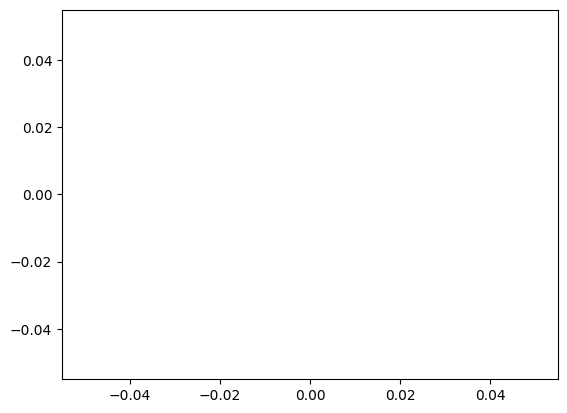

In [ ]:
# THIS WORKS ALMOST, BUT FACE RECOGNITION IS BAD AND SLOW
results = []
for frame in tqdm(video[:500]):
# for frame in video:
    # Convert torch tensor to numpy array
    start_ts = frame.pts_seconds if start_ts is None else start_ts
    end_ts = frame.pts_seconds

    cont_flag = 0

    frame = frame.data

    frame_np = frame.permute(1, 2, 0).numpy()

    # Extract faces from frame
    transform_time_start = time.time()
    detected_faces = DeepFace.extract_faces(
        frame_np, detector_backend = "ssd", enforce_detection=False, align=False
    )

    if detected_faces[0]["face"].shape == frame_np.shape:
        continue

    transform_time_end = time.time()

    # if len(detected_faces) == 0:
    #     continue

    # Convert faces to torch tensors
    face_px = [detected_face["face"] for detected_face in detected_faces]

    # Identify the correct face from frame

    sift_time_start = time.time()
    kpf = []
    desf = []

    for face in face_px:
        if len(np.unique(face)) == 1:
            cont_flag = 1
            continue

        face = (face * 255).astype(np.uint8)
        kp, des = sift.detectAndCompute(face, None)

        if des is None:
            cont_flag = 1
            continue

        kpf.append(kp)
        desf.append(des)

    sift_time_end = time.time()

    if cont_flag == 1:
        continue

    FLANN_INDEX_KDTREE = 1
    index_params = {
        "algorithm": FLANN_INDEX_KDTREE,
        "trees": 100
    }
    search_params = {
        "checks": 50
    }

    flann_time_start = time.time()
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    if any(len(t) <= 2 for t in desf):
        continue

    face_matches = [flann.knnMatch(des_ref, des_face, k=2) for des_face in desf]

    sim_scores = []
    for matches in face_matches:
        good_matches = []
        for m, n in matches:
            print(dir(m))
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        # Calculate similarity score
        similarity_score = len(good_matches) * 100 / len(kp_ref) if len(kp_ref) > 0 else 0
        sim_scores.append(similarity_score)
    break

    selected_face_idx = np.argmax(sim_scores)

    if sim_scores[selected_face_idx] <= 5:
        continue

    if len(face_matches) == 2:
        plt.subplot(1, 2, 1)
        plt.imshow(face_px[0][:,:,::-1])
        plt.subplot(1, 2, 2)
        plt.imshow(face_px[1][:,:,::-1])
        break
        # return similarity_score


    # len_fm = [len(t) for t in face_matches]

    # print("face_matches", len_fm)

    # max_match = max(face_matches, key=len)
    # selected_face_idx = face_matches.index(max_match)
    flann_time_end = time.time()

    # print("Transform time: ", transform_time_end - transform_time_start)
    # print("SIFT time: ", sift_time_end - sift_time_start)
    # print("FLANN time: ", flann_time_end - flann_time_start)
    # print("Total time: ",  flann_time_end - transform_time_start)

    # Store face in the snippet_frames list
    if len(face_matches) == 1:
        selected_face = face_px[selected_face_idx]

        snippet_frames.append(selected_face)
        face_locations.append({
            "x" : detected_faces[selected_face_idx]["facial_area"]['x'],
            "y" : detected_faces[selected_face_idx]["facial_area"]['y'],
            "w" : detected_faces[selected_face_idx]["facial_area"]['w'],
            "h" : detected_faces[selected_face_idx]["facial_area"]['h']
        })


    # If face not detected, write snippet_frames into video and clear snippet_frames list
    elif len(snippet_frames) == 0:
        continue

    # If background changes, then save the video, clear all vars, and continue
    fg_mask = bg_subtractor.apply(frame_np)
    height, width = fg_mask.shape
    total_pixels = height * width
    fg_pixels = np.count_nonzero(fg_mask)
    fg_percentage = fg_pixels / total_pixels

    if frame_count > 50 and fg_percentage > change_threshold:
        results = save_video(snippet_frames, file_count, results, start_ts, end_ts)
        snippet_frames = []
        face_locations = []

        file_count += 1

        start_ts = None


save_video(snippet_frames, file_count, results, start_ts, end_ts)
# plt.plot(simx)
# To write video, save all frames together for the face as one and then create a video with OpenCV. Also write timeframes, xywh info, and file name of saved clip into results dict

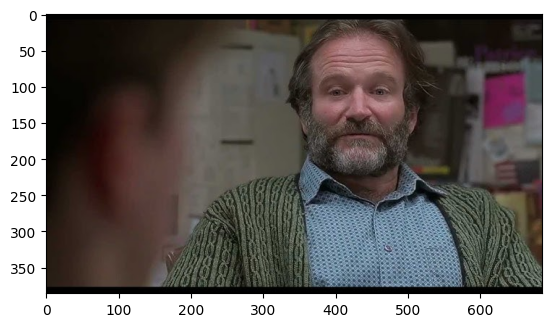

In [ ]:
plt.imshow(ref_img)

## Save results into JSON

In [ ]:
with open("metadata.json", "w") as f:
    json.dump(results, f, indent=4)

In [2]:
import os
import torch
from torchvision.models import VGG16_Weights, vgg16
from torchcodec.decoders import VideoDecoder
from deepface import DeepFace
import json
import cv2
import numpy as np
from tqdm.auto import tqdm
import logging

def save_video(snippet_frames, face_locations, file_count, results, start_ts, end_ts, fourcc=cv2.VideoWriter_fourcc(*'mp4v')):

    max_height = max([img.shape[0] for img in snippet_frames])
    max_width = max([img.shape[1] for img in snippet_frames])
    output_path = os.path.join(os.getcwd(), f"saved_file_{file_count}.mp4")

    video_writer = cv2.VideoWriter(
        filename=output_path,
        fourcc=fourcc,
        fps=config["generated_video_fps"],
        frameSize=(max_width, max_height)
    )

    for snippet in snippet_frames:
        img = (snippet * 255)

        padded_img = np.zeros((max_height, max_width, 3), dtype=img.dtype)
        start_y = (max_height - img.shape[0]) // 2
        start_x = (max_width - img.shape[1]) // 2
        padded_img[start_y:start_y+img.shape[0], start_x:start_x+img.shape[1]] = img

        img = padded_img

        video_writer.write(np.uint8(img))

    video_writer.release()

    results.append({
        "file_name": output_path,
        "face_clips": face_locations,
        "timestamp_start": float(start_ts.numpy()),
        "timestamp_end": float(end_ts.numpy())
    })

    return results

# Load configuration
if __name__ == "__main__":


    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    logger = logging.getLogger(__name__)
    # formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

    # Create handler and set formatter
    # handler = logging.StreamHandler()  # Or logging.FileHandler to output to a file
    # handler.setFormatter(formatter)

    # Add handler to the logger
    # logger.addHandler(handler)
    # logger.setLevel(logging.DEBUG)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    logger.info("Loading configuration file")

    # logger.log(logging.INFO, "Loading configuration file")

    with open("config.json", "r") as f:
        config = json.load(f)

    # Check if a NVIDIA accelerator is available or not
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # logger.log(logging.INFO, f"Using device: {device}")
    logger.info(f"Using device: {device}")

    # Load video and reference image using TorchCodec and OpenCV
    video = VideoDecoder(config["video_path"], num_ffmpeg_threads=0)
    video = video.get_frames_in_range(0, len(video))

    # logger.log(logging.INFO, f"Loaded video at path: {config['video_path']}")

    ref_img = cv2.cvtColor(cv2.imread(config["reference_image_path"]), cv2.COLOR_BGR2RGB)

    # logger.log(logging.INFO, f"Loaded reference image at path: {config['reference_image_path']}")
    logger.info(f"Loaded reference image at path: {config['reference_image_path']}")

    weights = VGG16_Weights.IMAGENET1K_FEATURES
    model = vgg16(weights=weights).to(device)

    transform = weights.transforms()

    # Remove dummy classifier layer and Flatten AdaptiveAvgPool2d layer outputs
    model.classifier = torch.nn.Flatten()

    # torch.compile for performance gains
    model = torch.compile(model, mode="max-autotune", fullgraph=True)

    # Define background subtraction tool to detect changes in background of video
    bg_subtractor = cv2.createBackgroundSubtractorMOG2(
        history=25,
        varThreshold=16,
        detectShadows=False
    )

    # Define constants
    CHANGE_THRESHOLD = 0.3
    FRAME_COUNT = 0
    START_TS = None
    END_TS = None
    FILE_COUNT = 1

    # Extract embeddings of reference image
    ref_img_torch = torch.from_numpy(ref_img).permute(2, 0, 1).to(device)
    ref_img_emb = model(transform(ref_img_torch).unsqueeze(0))

    # Define lists to store frames and face locations
    snippet_frames = []
    face_locations = []
    results = []

    # Running loop over the video
    for frame in tqdm(video):
        # Keep track of the timestamps for the current clip being processed
        START_TS = frame.pts_seconds if START_TS is None else START_TS
        END_TS = frame.pts_seconds

        frame = frame.data
        frame_np = frame.permute(1, 2, 0).numpy()

        # Extract faces from the frame using Haar Cascades
        detected_faces = DeepFace.extract_faces(
            frame_np,
            detector_backend = "opencv",
            enforce_detection=False,
            align=False
        )

        # Condition: If no faces are detected, continue to the next frame
        if detected_faces[0]["face"].shape == frame_np.shape:
            continue

        # Extract facial area from the detected-faces object
        face_px = [detected_face["face"] for detected_face in detected_faces]

        with torch.no_grad():
            # Create torch.Tensors out of each face extracted
            face_emb_inputs = [torch.from_numpy(face).permute(2, 1, 0) for face in face_px]

            # Perform required transformations on the tensors before using with the model
            face_emb_transforms = torch.stack([transform(face) for face in face_emb_inputs])

            # Move the transformed tensors to the device
            face_emb_transforms = face_emb_transforms.to(device)

            # Extract embeddings of the faces
            face_embs = model(face_emb_transforms)

            # Calculate the euclidean distance between the face embeddings and the reference image embedding
            face_euclidean_dist = torch.cdist(face_embs, ref_img_emb, p=1)

            # Select the face with the minimum euclidean distance
            selected_face_idx = torch.argmin(face_euclidean_dist).int()

        # Condition: If the face is the same as the reference image or there are two faces detected, append the face to the snippet_frames list
        if (len(face_euclidean_dist) == 1 and face_euclidean_dist[0] < 70000) or len(face_euclidean_dist) == 2:
            selected_face = face_px[selected_face_idx]

            snippet_frames.append(selected_face)

            face_locations.append({
                "x" : detected_faces[selected_face_idx]["facial_area"]['x'],
                "y" : detected_faces[selected_face_idx]["facial_area"]['y'],
                "w" : detected_faces[selected_face_idx]["facial_area"]['w'],
                "h" : detected_faces[selected_face_idx]["facial_area"]['h']
            })

        # Condition: If the snippet_frames list is empty, continue to the next frame
        elif len(snippet_frames) == 0:
            continue

        # Condition: If the snippet_frames list is not empty, apply background subtraction to the frame
        # to check if the background has changed using Mixture of Gaussians
        fg_mask = bg_subtractor.apply(frame_np)
        height, width = fg_mask.shape
        total_pixels = height * width
        fg_pixels = np.count_nonzero(fg_mask)
        fg_percentage = fg_pixels / total_pixels

        if FRAME_COUNT > 50 and fg_percentage > CHANGE_THRESHOLD:
            # Save the video snippet
            # logger.log(logging.INFO, f"Saving video snippet from {START_TS} seconds to {END_TS} seconds")
            logger.info(f"Saving video snippet from {START_TS} seconds to {END_TS} seconds")
            results = save_video(
                snippet_frames=snippet_frames,
                face_locations=face_locations,
                file_count=FILE_COUNT,
                results=results,
                start_ts=START_TS,
                end_ts=END_TS
            )

            # Reset all running variables
            snippet_frames = []
            face_locations = []

            FILE_COUNT += 1

            START_TS = None

    # Save all remaining frames in the last video clip

    # logger.log(logging.INFO, f"Saving final video snippet from {START_TS} seconds to {END_TS} seconds")
    logger.info(f"Saving final video snippet from {START_TS} seconds to {END_TS} seconds")

    save_video(
        snippet_frames=snippet_frames,
        face_locations=face_locations,
        file_count=FILE_COUNT,
        results=results,
        start_ts=START_TS,
        end_ts=END_TS
    )

    # logger.log(logging.INFO, "All video snippets saved successfully!")
    logger.info("All video snippets saved successfully!")

    # Save metadata to a JSON file
    with open("metadata.json", "w") as f:
        json.dump(results, f, indent=4)

    # logger.log(logging.INFO, "Metadata saved successfully!")
    logger.info("Metadata saved successfully!")


  0%|          | 0/7276 [00:00<?, ?it/s]

In [ ]:
!python app.py

2024-12-17 18:33:40.556054: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 18:33:40.578178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-17 18:33:40.602221: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-17 18:33:40.609633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 18:33:40.627851: I tensorflow/core/platform/cpu_feature_guar